In [2]:
import sys
sys.path.append('../')
from deep_rl.gridworld import ReachGridWorld, PickGridWorld, PORGBEnv, GoalManager, ScaleObsEnv
from deep_rl.network import *
from deep_rl.utils import *
import os
import random
import dill
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import Counter, namedtuple, defaultdict
from IPython.display import display
from PIL import Image
from pathlib import Path
from IPython.core.debugger import Tracer
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)

set_seed(0) # set seed 

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 10)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.1 * v)) for v in range(1, 10)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.1 * v)) for v in range(1, 10)],
    *[('green-{}'.format(v), plt.cm.Greens(0.1 * v)) for v in range(1, 10)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.1 * v)) for v in range(1, 10)],
    *[('red-{}'.format(v), plt.cm.Reds(0.1 * v)) for v in range(1, 10)],
])

color_list = list(color_map.values())
shuffle(color_list)
# goal, wall, undefined, abstract states
color_list = [plt.cm.Greys(0.0), plt.cm.Greys(0.5), plt.cm.Greys(0.9)] + color_list
drawer = GridDrawer(color_list)

def imshow(img):
    display(Image.fromarray(np.asarray(img).astype(np.uint8)))

def fload(fn, ftype):
    if ftype == 'json':
        with open(fn) as f:
            return json.load(f)
    elif ftype == 'pkl':
        with open(fn, 'rb') as f:
            return dill.load(f)
    elif ftype == 'png':
        raise NotImplementedError
    else:
        raise Exception('cannot read this data type: {}'.format(ftype))
    
def fsave(data, fn, ftype):
    dirname = os.path.dirname(fn)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    if ftype == 'json':
        with open(fn, 'w') as f:
            json.dump(data, f)
    elif ftype == 'pkl':
        with open(fn, 'wb') as f:
            dill.dump(data, f)    
    elif ftype == 'png':
        Image.fromarray(data).save(fn)
    else:
        raise Exception('unsupported file type: {}'.format(ftype))
        
class one_hot:
    # 1 or 2 dim
    @staticmethod
    def encode(indices, dim):
        if len(indices.shape) > 1:
            indices = indices.squeeze(axis=1)
        assert len(indices.shape) == 1, 'shape error'
        return np.eye(dim)[indices]

    # 2-dim
    @staticmethod
    def decode(vs):
        return np.argmax(vs, 1)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
def get_envs():
    envs = dict()
    states = []
    positions = []
    for i in range(9):
        with open('../data/env_configs/pick/nineroom/nineroom.{}'.format(i), 'rb') as f:
            env_config = dill.load(f)
            #env_config['map_names'] = ['map48']
        envs[i] = ScaleObsEnv(
            PickGridWorld(
                    **env_config,
                    min_dis=1,
                    window=1,
                    task_length=1,
                    seed=0,
            ),
            2,
        )
        envs[i].reset(sample_obj_pos=False)
        if not positions:
            positions = envs[i].unwrapped.pos_candidates
        if not states:
            for pos in positions:
                o, _, _, _ = envs[i].teleport(*pos)
                states.append(o)
    return envs, states, positions

def get_abs_img(abs_map, env):
    m = env.unwrapped.get_map(0)
    indices = np.zeros((len(m), len(m[0])), dtype=np.int64)
    for i in range(len(m)):
        for j in range(len(m[0])):
            if (i, j) in env.unwrapped.default_obj_pos[0]:
                indices[i][j] = 0
            elif m[i][j] == '#':
                indices[i][j] = 1
            elif (i, j) in abs_map:
                x = abs_map[(i, j)]
                if isinstance(x, int):
                    indices[i][j] = 3 + x
                else: # probability
                    #print(x)
                    if np.max(x) > 0.5: # a threshold
                        indices[i][j] = 3 + np.argmax(x)
                    else:
                        indices[i][j] = 2
    return drawer.draw(indices)

# Action Clustering   

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 0)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 1)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 2)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, (

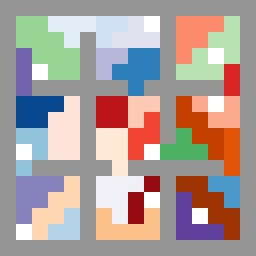

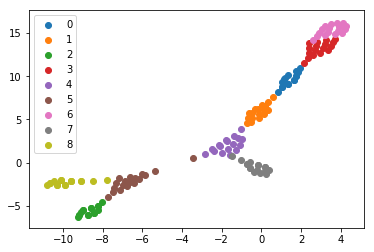

In [29]:
n_abs = 30

envs, _, positions = get_envs()

# get features
features = []
for pos in positions:
    feature = []
    #feature = np.zeros(5)
    for i in range(9):
        envs[i].teleport(*pos)
        qs = np.array(envs[i].get_q(0.99))
        best_actions = (qs == qs.max()).astype(int)
        #feature.append(one_hot.encode(np.array([envs[i].get_opt_action()]), 5).squeeze(0))
        #feature.append(best_actions)
        #feature += best_actions
        feature.append([qs.max()])
    features.append(np.concatenate(feature))
    #features.append(feature)

# visualize by TSNE
embedding = TSNE(n_components=2).fit_transform(features)
colors = [pos[0] // 5 * 3 + pos[1] // 5 for pos in positions]
scatters = defaultdict(list)
for pos, emb in zip(positions, embedding):
    scatters[pos[0] // 5 * 3 + pos[1] // 5].append(emb)

for i in range(9):
    emb = np.asarray(scatters[i])
    plt.scatter(emb[:, 0], emb[:, 1], label=i)
    
plt.legend()
    
# clustering
clustering = GaussianMixture(n_abs, 'spherical')
clustering.fit(features)
probs = clustering.predict_proba(features)
print(clustering.weights_)
print(clustering.means_)
abs_map = {s: prob for s, prob in zip(positions, probs)}

# visualization
img = get_abs_img(abs_map, list(envs.values())[0])
imshow(img)

# expert policy clustering

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 0)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 1)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 2)]
test: [(0, 0)]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, (

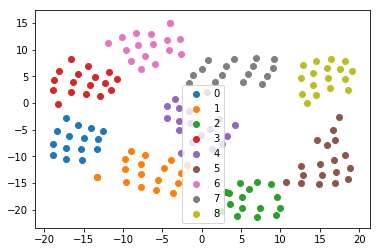

In [8]:
feat_dim = 50#512
action_dim = 5
horizon = 100
scale = 2
n_objs = 9

set_seed(0)

def get_expert(weight_path):
    visual_body = TSAMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        #gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

expert_dict = {
    0: '../log/pick.mask.nineroom.0.min_dis-1/tsa.baseline.n_abs-512/relu/0.190327-232308/models/step-491520-mean-10.70',
    1: '../log/pick.mask.nineroom.1.min_dis-1/tsa.baseline.n_abs-512/relu/1.190327-235057/models/step-491520-mean-10.84',
    2: '../log/pick.mask.nineroom.2.min_dis-1/tsa.baseline.n_abs-512/relu/1.190328-000958/models/step-491520-mean-10.86',
    3: '../log/pick.mask.nineroom.3.min_dis-1/tsa.baseline.n_abs-512/relu/2.190328-003751/models/step-491520-mean-10.71',
    4: '../log/pick.mask.nineroom.4.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-005600/models/step-491520-mean-10.81',
    5: '../log/pick.mask.nineroom.5.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-011456/models/step-491520-mean-10.78',
    6: '../log/pick.mask.nineroom.6.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-014223/models/step-491520-mean-10.82',
    7: '../log/pick.mask.nineroom.7.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-020127/models/step-491520-mean-10.84',
    8: '../log/pick.mask.nineroom.8.min_dis-1/tsa.baseline.n_abs-512/relu/0.190330-165152/models/step-491520-mean-10.80',
}

envs, states, positions = get_envs()

def from_expert():
    experts = dict()
    for goal_idx, weight_path in expert_dict.items():
        experts[goal_idx] = get_expert(weight_path)
    pvs = []
    abvs = []
    for goal_idx in [0]:#expert_dict:
        cur_infos = {'task_id': [goal_idx] * len(states)}
        pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
        pvs.append(pv)
        abv = experts[goal_idx].network.phi_body(tensor(states)).cpu().detach().numpy()
        abvs.append(abv)
    features = np.concatenate(pvs, 1)
    abvs = np.concatenate(abvs, 1)
    return features, abvs

def from_actor_mimic():
    policy = get_expert('../log/pick.mask.nineroom.e8.min_dis-1/imitation.baseline.n_abs-512/50_follow_opt/0.190419-174720/models/step-974080-mean-10.77')
    cur_infos = {'task_id': [0] * len(states)}
    pv = F.softmax(policy.get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    abv = policy.network.phi_body(tensor(states)).cpu().detach().numpy()
    return pv, abv

#features, abvs = from_expert()
features, abvs = from_actor_mimic()

# visualize by TSNE
#embedding = TSNE(n_components=2).fit_transform(features)
embedding = TSNE(n_components=2).fit_transform(abvs)
colors = [pos[0] // 5 * 3 + pos[1] // 5 for pos in positions]
scatters = defaultdict(list)
for pos, emb in zip(positions, embedding):
    scatters[pos[0] // 5 * 3 + pos[1] // 5].append(emb)

for i in range(9):
    emb = np.asarray(scatters[i])
    plt.scatter(emb[:, 0], emb[:, 1], label=i)
    

    
plt.legend()

# NMF clustering